# KNN in predicting stock price

In [1]:
# Base Libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# plt.rcParams['figure.figsize'] = (20,7)
# plt.style.use('fivethirtyeight')
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split,
                                    GridSearchCV,
                                    TimeSeriesSplit,
                                    cross_val_score
)

# Classifier
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import (precision_recall_curve,
roc_curve,
RocCurveDisplay,
ConfusionMatrixDisplay
)
from sklearn.metrics import (accuracy_score,
f1_score,
recall_score,
precision_score,
roc_auc_score,
auc
)
from sklearn.metrics import (classification_report,
confusion_matrix
)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load locally stored data
df = pd.read_csv('../10_KNN_n_SVR/spy.csv', index_col=0, parse_dates=True)
# Check first 5 values
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,146.84375,147.50000,146.250000,146.8750,100.376900,3172700
2000-01-03,148.25000,148.25000,143.875000,145.4375,99.394493,8164300
2000-01-04,143.53125,144.06250,139.640625,139.7500,95.507530,8089800
2000-01-05,139.93750,141.53125,137.250000,140.0000,95.678391,12177900
2000-01-06,139.62500,141.50000,137.750000,137.7500,94.140717,6227200


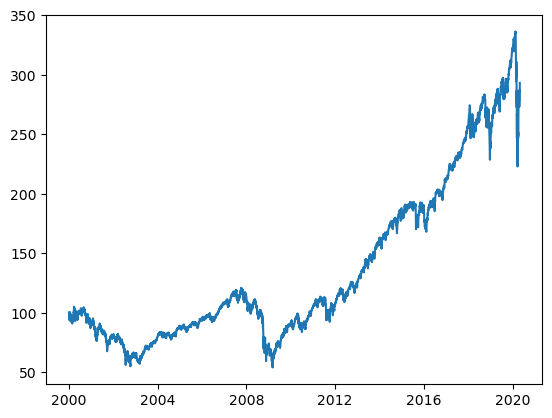

In [3]:
# Visualize data
plt.plot(df['Adj Close']);

In [4]:
# Descriptive statistics
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5114.000000,5114.000000,5114.000000,5114.000000,5114.000000,5.114000e+03
mean,159.857972,160.798386,158.829985,159.860942,136.333938,1.127593e+08
std,60.679463,60.830274,60.515930,60.694065,67.923663,9.870486e+07
min,67.949997,70.000000,67.099998,68.110001,54.184429,1.436600e+06
25%,115.752501,116.662502,114.902502,115.897499,87.412493,4.821255e+07
50%,137.085007,137.955002,136.110001,136.945000,106.488850,8.357545e+07
75%,201.767498,202.787498,200.722504,201.872505,182.951584,1.515544e+08
max,337.790009,339.079987,337.480011,338.339996,336.362091,8.710263e+08


Normally we would clean the data but in this file the data is already cleaned.

In [5]:
# Check for missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# Predictors
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low

X = df[['O-C', 'H-L']].values
X

array([[-0.03125   ,  1.25      ],
       [ 2.8125    ,  4.375     ],
       [ 3.78125   ,  4.421875  ],
       ...,
       [-1.92999268,  3.6499939 ],
       [ 5.28997803,  6.        ],
       [-1.67999268,  4.47000122]])

We will create a target lable. With the trading experience, we will buy if we know the "future" price is rising and sell if dipping. The threatshold is 5%. We will choose the lable `+1` for buy and `-1` for sell.

$$
y_t = \left\{ \begin{array}{cl} &+1, \quad \forall p_{t+1} > 0.995 \times p_t \\ &-1 \end{array} \right.
$$

In [7]:
# Target- Avoid using [-1, 1], always prefer [0, 1] as class labels
y = np.where(df['Adj Close'].shift(-1)>0.995*df['Adj Close'],1,-1)
y

array([-1, -1,  1, ...,  1,  1, -1])

In [8]:
# Value counts for class 1 and -1
pd.Series(y).value_counts()

 1    3885
-1    1229
Name: count, dtype: int64

In [9]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4091, 1023


### Train the base model

In [10]:
# Scale and fit the model
model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("classifier", KNeighborsClassifier())
])
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', KNeighborsClassifier())])

In [11]:
# Predicting the test dataset
y_pred = model.predict(X_test)
# Predict Probabilities
y_proba = model.predict_proba(X_test)

In [12]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.7802, Test Accuracy: 0.7498


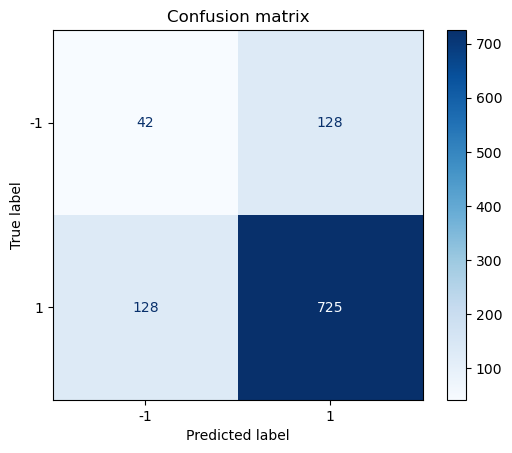

In [13]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        # display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

In [14]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.25      0.25      0.25       170
           1       0.85      0.85      0.85       853

    accuracy                           0.75      1023
   macro avg       0.55      0.55      0.55      1023
weighted avg       0.75      0.75      0.75      1023



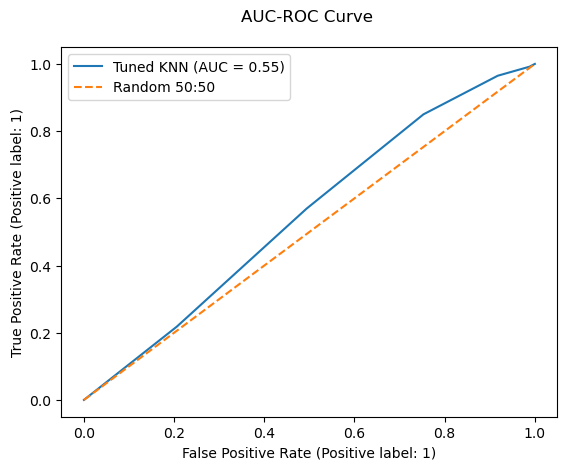

In [15]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
        model,
        X_test,
        y_test,
        name = 'Tuned KNN')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

### Tunning hyper-params

In [16]:
# Example: First 2 split
tscv = TimeSeriesSplit(n_splits=4, gap=1)   # Time Series Cross Validation `tscv`
for train, test in tscv.split(X):
    print(train, test)

[   0    1    2 ... 1022 1023 1024] [1026 1027 1028 ... 2045 2046 2047]
[   0    1    2 ... 2044 2045 2046] [2048 2049 2050 ... 3067 3068 3069]
[   0    1    2 ... 3066 3067 3068] [3070 3071 3072 ... 4089 4090 4091]
[   0    1    2 ... 4088 4089 4090] [4092 4093 4094 ... 5111 5112 5113]


In [17]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [18]:
# Get parameters list
model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('classifier', KNeighborsClassifier())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': KNeighborsClassifier(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 5,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

Select number of neighbours from 1 to 50 and observe the accuracy

In [19]:
# Perform Gridsearch and fit
param_grid = {"classifier__n_neighbors": np.arange(1,51,1)}

gs = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=tscv, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='roc_auc', verbose=1)

In [20]:
# Best Params & Scores
print(f"Optimal Neighbours: {gs.best_params_['classifier__n_neighbors']}, Best Score: {round(gs.best_score_,4)}")

Optimal Neighbours: 18, Best Score: 0.5358


### Tunned model

In [21]:
# Instantiate KNN model with search param
clf = KNeighborsClassifier(n_neighbors = gs.best_params_['classifier__n_neighbors'])
# Fit the model
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=18)

In [22]:
# Predicting the test dataset
y_pred = clf.predict(X_test)
# Predict Probabilities
# y_proba = clf.predict_proba(X_test)[:,1]

# Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.7473 
 Test Accuracy 		: 0.7859


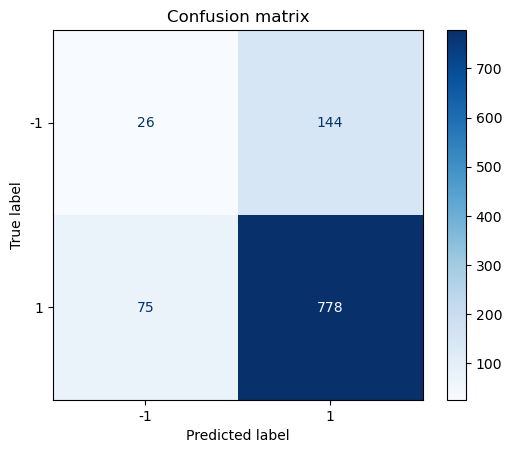

In [23]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=model.classes_,
        cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

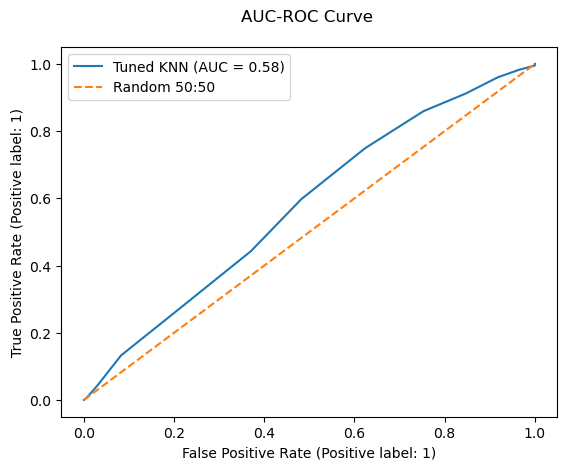

In [24]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
clf,
X_test,
y_test,
name='Tuned KNN')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [25]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.26      0.15      0.19       170
           1       0.84      0.91      0.88       853

    accuracy                           0.79      1023
   macro avg       0.55      0.53      0.53      1023
weighted avg       0.75      0.79      0.76      1023



### Trading Strategy

In [26]:
# Subsume into a new dataframe
df1 = df.copy()                 # df[-len(X_test)
df1['Signal'] = clf.predict(X)  # clf.predict(X_test)

In [27]:
# Daily Returns - Benchmark return
df1['Returns'] = np.log(df1['Adj Close']).diff().fillna(0)
# Strategy Returns - KNN
df1['Strategy'] = df1['Returns'] * df1['Signal'].shift(1).fillna(0)
# Localize index for pyfolio
df1.index = df1.index.tz_localize('utc')

In [28]:
# Check the output
df1.tail(10)

,Open,High,Low,Close,Adj Close,Volume,O-C,H-L,Signal,Returns,Strategy
Date,,,,,,,,,,,
2020-04-16 00:00:00+00:00,279.149994,280.029999,275.760010,279.100006,279.100006,131798300,0.049988,4.269989,1,0.004813,0.004813
2020-04-17 00:00:00+00:00,285.380005,287.299988,282.399994,286.640015,286.640015,146684800,-1.260010,4.899994,1,0.026657,0.026657
2020-04-20 00:00:00+00:00,282.609985,286.790009,281.350006,281.589996,281.589996,100109300,1.019989,5.440002,1,-0.017775,-0.017775
2020-04-21 00:00:00+00:00,276.730011,278.040009,272.019989,273.040009,273.040009,126385700,3.690002,6.020020,1,-0.030834,-0.030834
2020-04-22 00:00:00+00:00,278.350006,281.000000,276.910004,279.100006,279.100006,93524600,-0.750000,4.089996,-1,0.021952,0.021952
2020-04-23 00:00:00+00:00,280.489990,283.940002,278.750000,279.079987,279.079987,104709700,1.410004,5.190002,1,-0.000072,0.000072
2020-04-24 00:00:00+00:00,280.730011,283.700012,278.500000,282.970001,282.970001,85166000,-2.239990,5.200012,1,0.013842,0.013842
2020-04-27 00:00:00+00:00,285.119995,288.269989,284.619995,287.049988,287.049988,77896600,-1.929993,3.649994,-1,0.014315,0.014315
2020-04-28 00:00:00+00:00,291.019989,291.399994,285.399994,285.730011,285.730011,105270000,5.289978,6.000000,1,-0.004609,0.004609
